# (Conditional) Generative Adversarial Networks

This notebook implements a basic generative adversarial network (GAN) [1]. In particular, we implement a conditional variant (CGAN) [2] that generates MNIST digits conditioned on passed labels.

### References

1. I. J. Goodfellow et al., “Generative Adversarial Networks.” arXiv, Jun. 10, 2014. Accessed: Dec. 17, 2023. arXiv:1406.2661.
2. M. Mirza and S. Osindero, “Conditional Generative Adversarial Nets.” arXiv, Nov. 06, 2014. doi: 10.48550/arXiv.1411.1784.


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as transforms

In [28]:
from typing import Optional

## Dataset

In this implementation, we will use the MNIST dataset and generate images of handwritten digits, conditioned on their label.

In [29]:
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
train_data = torchvision.datasets.MNIST(
    root="./assets/data/mnist",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
    ])
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

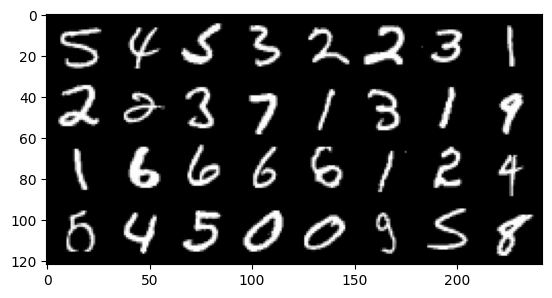

In [31]:
img = next(iter(train_loader))[0][:32] # get a random batch of images
img = torchvision.utils.make_grid(img)
plt.imshow(img.permute(1, 2, 0));

## Model

The model comprises out of two networks, the *generator* trained to generate images matching those found in the training distribution, and the *discriminator* trained to discriminate between real and fake images.

In [32]:
from microai.models.gan import Generator, Discriminator

In [33]:
n_labels = 10           # total number of conditioning labels (10 digits in our MNIST case)
z_dim = 100             # prior dimensionality
img_shape = (1, 28, 28) # dimension of the image

In [34]:
generator = Generator(n_labels=n_labels, z_dim=z_dim, img_shape=img_shape).to(device)
discriminator = Discriminator(n_labels=n_labels, img_shape=img_shape).to(device)

## Training

Diverging slightly from the original implementation, we alternate between a single step of optimization of the generator and the discriminator (the original paper performed $k$ optimization steps of the discriminator, for every step of optimizing the generator).

In [35]:
epochs = 200
lr = 1e-3

In [36]:
opt_generator = torch.optim.Adam(generator.parameters(), lr=lr)
opt_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [37]:
for epoch in range(1, epochs + 1):
    loss_gen, loss_disc = [], []

    for x_true, y_true in train_loader:
        batch_size = y_true.size(0)
        x_true, y_true = x_true.to(device), y_true.to(device)

        # generate an image batch
        y_gen = torch.randint(0, n_labels, size=(batch_size, ), device=device)
        z_gen = torch.normal(0, 1, size=(batch_size, z_dim), device=device)
        x_gen = generator(z_gen, y_gen)

        # train generator
        y_target = torch.ones_like(y_true).float()
        y_pred = discriminator(x_gen, y_gen).flatten()

        opt_generator.zero_grad()
        loss = F.mse_loss(y_pred, y_target)
        loss.backward()
        opt_generator.step()
        loss_gen.append(loss.detach().cpu().mean().item())

        # train discriminator
        y_target = torch.cat((torch.ones_like(y_true), torch.zeros_like(y_gen)), dim=0).float()
        labels = torch.cat((y_true, y_gen))
        input = torch.cat((x_true, x_gen.detach()))
        y_pred = discriminator(input, labels).flatten()

        opt_discriminator.zero_grad()
        loss = F.mse_loss(y_pred, y_target)
        loss.backward()
        opt_discriminator.step()
        loss_disc.append(loss.detach().cpu().mean().item())

    print(f"epoch={epoch}; loss_discriminator={np.mean(loss_disc):.3f}; loss_generator={np.mean(loss_gen):.3f}")

epoch=1; loss_discriminator=0.005; loss_generator=0.990
epoch=2; loss_discriminator=0.002; loss_generator=0.994
epoch=3; loss_discriminator=0.002; loss_generator=0.991
epoch=4; loss_discriminator=0.002; loss_generator=0.992
epoch=5; loss_discriminator=0.003; loss_generator=0.991
epoch=6; loss_discriminator=0.004; loss_generator=0.987
epoch=7; loss_discriminator=0.006; loss_generator=0.980
epoch=8; loss_discriminator=0.008; loss_generator=0.975
epoch=9; loss_discriminator=0.009; loss_generator=0.971
epoch=10; loss_discriminator=0.010; loss_generator=0.968
epoch=11; loss_discriminator=0.013; loss_generator=0.961
epoch=12; loss_discriminator=0.022; loss_generator=0.932
epoch=13; loss_discriminator=0.026; loss_generator=0.921
epoch=14; loss_discriminator=0.039; loss_generator=0.882
epoch=15; loss_discriminator=0.052; loss_generator=0.841
epoch=16; loss_discriminator=0.060; loss_generator=0.814
epoch=17; loss_discriminator=0.070; loss_generator=0.784
epoch=18; loss_discriminator=0.078; loss

## Generation

Lastly, we generate few images from our trained model.

In [40]:
@torch.no_grad()
def generate(labels: Optional[torch.Tensor] = None):
    labels = labels.to(device) if labels is not None else torch.arange(n_labels).long().to(device)
    z = torch.normal(0, 1, size=(labels.size(0), z_dim), device=device)
    return generator(z, labels)

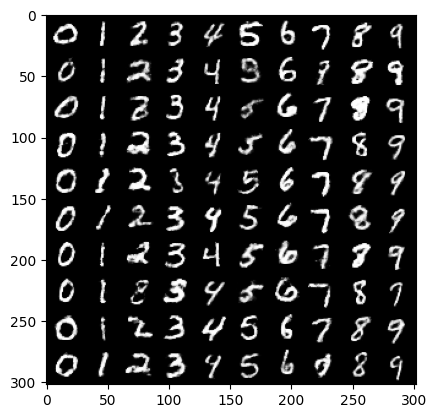

In [41]:
images = [generate(labels=torch.arange(n_labels).long()) for _ in range(10)]
images = torch.cat(images)
images = torchvision.utils.make_grid(images.cpu(), normalize=True, nrow=10)
plt.imshow(images.permute(1, 2, 0).detach().cpu().numpy());